In [32]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

## Biased Pauli Noise
Here we will be considering Biased Pauli


In [17]:
noise_model = NoiseModel()

p_err = 0.02
b_err = 0.0010
error_1q = pauli_error([('I',1-p_err-b_err),('X',p_err/3),('Y',p_err/3),('Z',p_err/3+b_err)]) # 1 qubit Biased Pauli error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

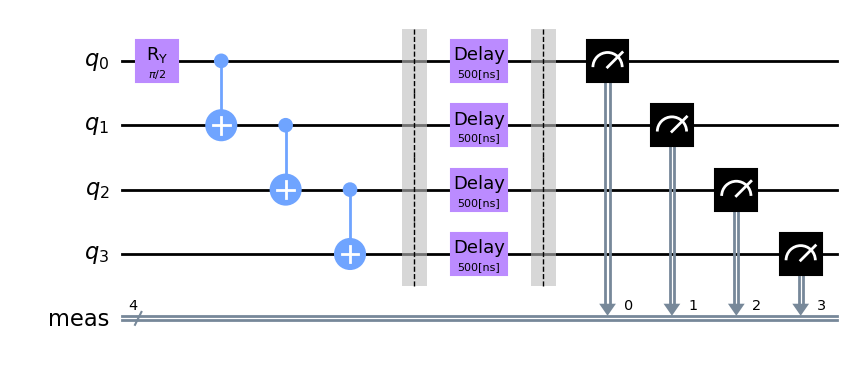

In [18]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(500,unit='ns')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

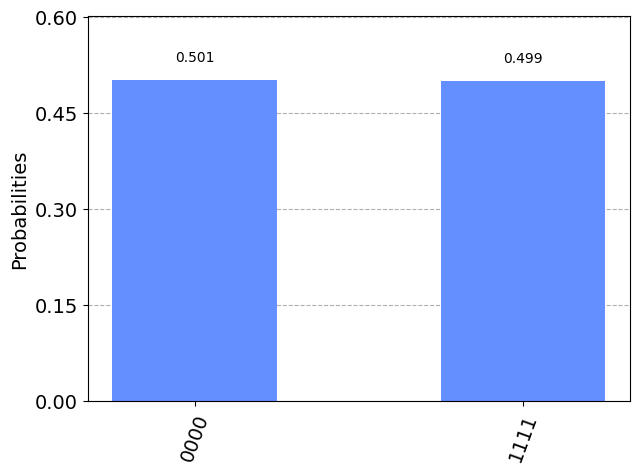

In [19]:
#Backend without Noise
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)


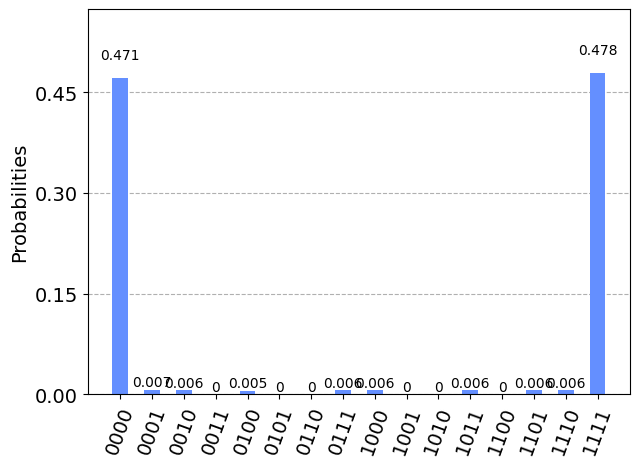

In [20]:
#Backend with noise
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

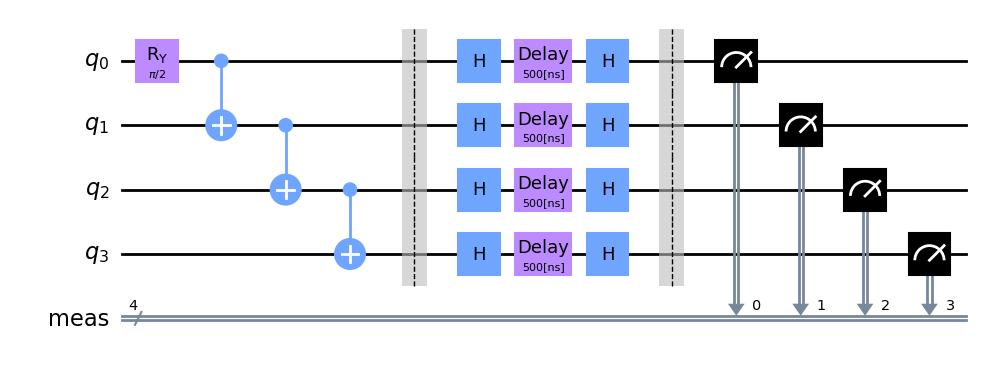

In [21]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
    qc.delay(delay,qubit,unit='ns')
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


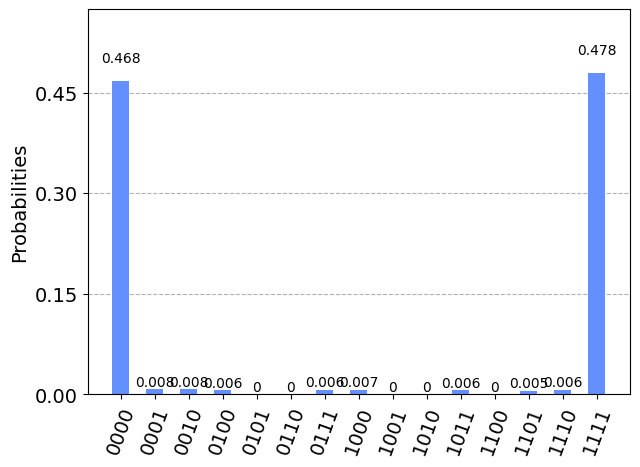

In [22]:
#Backend with Noise and padding both sides with the Hadamard gate
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

In [23]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 5000/10000
    else:
        wt = counts[state]-5000
        if (wt >= 0):
            diff += wt # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }


In [24]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error without noise: {cost(counts_ideal)}")
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")

Error without noise: {'invalid_states_count': 0, 'deviation': 8, 'error': 0.0008}
Error with noise without hadamard: {'invalid_states_count': 504, 'deviation': 0, 'error': 0.0504}
Error with noise with hadamard: {'invalid_states_count': 537, 'deviation': 0, 'error': 0.0537}


In [25]:
# Complete this function
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  
  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  return circuits

ckts = pad_circuits_with_gates(4,pi/2,500)

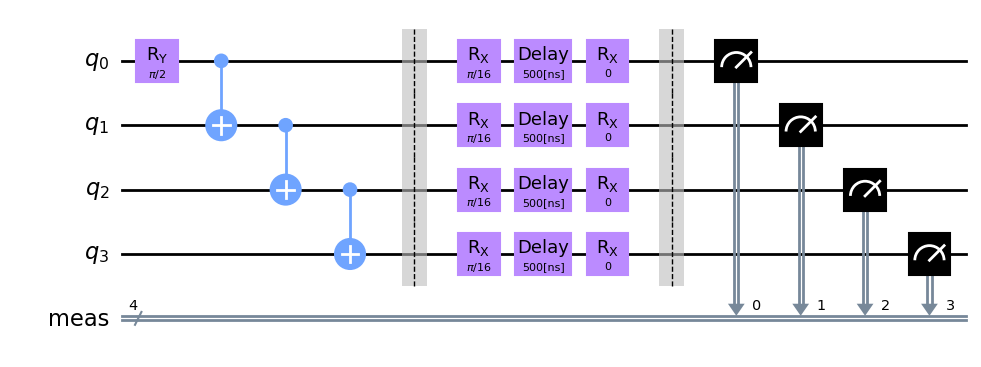

In [26]:
ckts[128][0].draw('mpl')

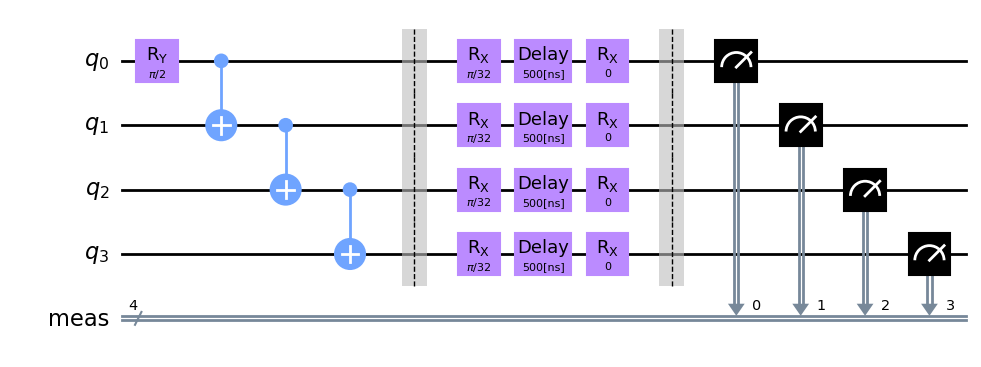

In [27]:
ckts[64][0].draw('mpl')

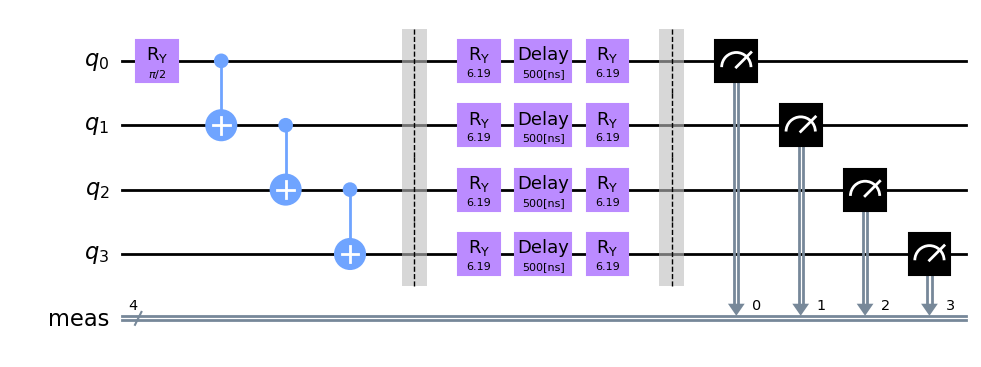

In [28]:
ckts[16383][0].draw('mpl')

In [29]:
def getError(ckt_info):
  return ckt_info['error']

In [30]:
from tqdm import tqdm
min_error = 999999
min_err_info = None
min_ckt = None
theta = []
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████| 16384/16384 [04:40<00:00, 58.47it/s]


In [33]:
print(error[0])

{'invalid_states_count': 475, 'deviation': 0, 'error': 0.0475, 'index': 14368}


#### Now we wish to change the noise model

In [38]:
from biased_pauli_template import biased_pauli as bp
min_ckt, min_err_info, min_error = bp(p_err=0.03, b_err=0.0025, delay_time=600)

100%|██████████| 16384/16384 [10:10<00:00, 26.85it/s]


{'invalid_states_count': 711, 'deviation': 0, 'error': 0.0711, 'index': 2206}


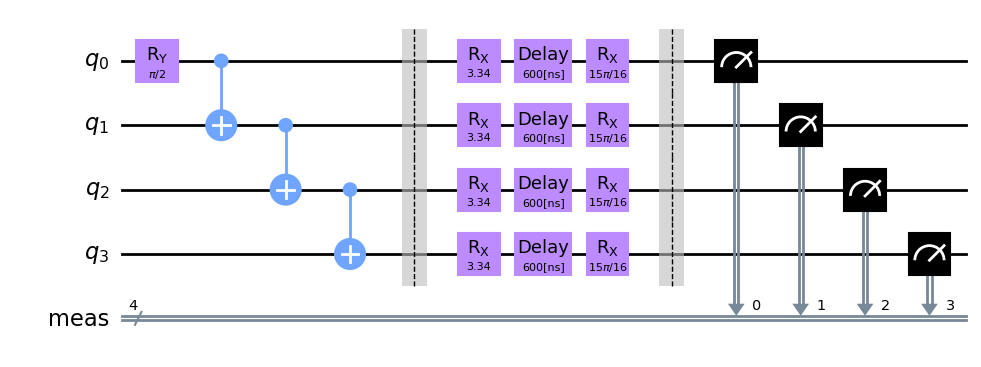

In [39]:
print(min_err_info)
min_ckt.draw('mpl')

In [42]:
from tqdm import tqdm
ckts_list = []
error_list = []
error_dict_list = []

for delay in tqdm(range(500,800,100)):
  p_err=0.01
  while(p_err<=0.035):  
    b_err = 0.0005
    while(b_err<=0.0025):
      print(f"@@@@@  delay = {delay} noise_prob = {p_err} b_err = {b_err}")
      min_ckt, min_err_info, min_error = bp(p_err,b_err,delay)
      ckts_list.append(min_ckt)
      error_dict_list.append(min_err_info)
      error_list.append(min_error)
      b_err += 0.0005
    p_err += 0.005

  0%|          | 0/3 [00:00<?, ?it/s]

@@@@@  delay = 500 noise_prob = 0.01 b_err = 0.0005


100%|██████████| 16384/16384 [06:39<00:00, 41.06it/s]


@@@@@  delay = 500 noise_prob = 0.01 b_err = 0.001


100%|██████████| 16384/16384 [06:02<00:00, 45.16it/s]


@@@@@  delay = 500 noise_prob = 0.01 b_err = 0.0015


100%|██████████| 16384/16384 [06:06<00:00, 44.73it/s]


@@@@@  delay = 500 noise_prob = 0.01 b_err = 0.002


100%|██████████| 16384/16384 [04:54<00:00, 55.66it/s]


@@@@@  delay = 500 noise_prob = 0.01 b_err = 0.0025


100%|██████████| 16384/16384 [04:41<00:00, 58.26it/s]


@@@@@  delay = 500 noise_prob = 0.015 b_err = 0.0005


100%|██████████| 16384/16384 [04:41<00:00, 58.14it/s]


@@@@@  delay = 500 noise_prob = 0.015 b_err = 0.001


100%|██████████| 16384/16384 [04:41<00:00, 58.20it/s]


@@@@@  delay = 500 noise_prob = 0.015 b_err = 0.0015


100%|██████████| 16384/16384 [04:41<00:00, 58.10it/s]


@@@@@  delay = 500 noise_prob = 0.015 b_err = 0.002


100%|██████████| 16384/16384 [04:39<00:00, 58.57it/s]


@@@@@  delay = 500 noise_prob = 0.015 b_err = 0.0025


100%|██████████| 16384/16384 [04:32<00:00, 60.02it/s]


@@@@@  delay = 500 noise_prob = 0.02 b_err = 0.0005


100%|██████████| 16384/16384 [04:35<00:00, 59.38it/s]


@@@@@  delay = 500 noise_prob = 0.02 b_err = 0.001


100%|██████████| 16384/16384 [04:33<00:00, 59.82it/s]


@@@@@  delay = 500 noise_prob = 0.02 b_err = 0.0015


100%|██████████| 16384/16384 [04:32<00:00, 60.11it/s]


@@@@@  delay = 500 noise_prob = 0.02 b_err = 0.002


100%|██████████| 16384/16384 [04:32<00:00, 60.02it/s]


@@@@@  delay = 500 noise_prob = 0.02 b_err = 0.0025


100%|██████████| 16384/16384 [04:33<00:00, 59.83it/s]


@@@@@  delay = 500 noise_prob = 0.025 b_err = 0.0005


100%|██████████| 16384/16384 [04:32<00:00, 60.10it/s]


@@@@@  delay = 500 noise_prob = 0.025 b_err = 0.001


100%|██████████| 16384/16384 [04:33<00:00, 59.99it/s]


@@@@@  delay = 500 noise_prob = 0.025 b_err = 0.0015


100%|██████████| 16384/16384 [04:33<00:00, 60.00it/s]


@@@@@  delay = 500 noise_prob = 0.025 b_err = 0.002


100%|██████████| 16384/16384 [04:33<00:00, 60.01it/s]


@@@@@  delay = 500 noise_prob = 0.025 b_err = 0.0025


100%|██████████| 16384/16384 [04:31<00:00, 60.40it/s]


@@@@@  delay = 500 noise_prob = 0.030000000000000002 b_err = 0.0005


100%|██████████| 16384/16384 [04:32<00:00, 60.18it/s]


@@@@@  delay = 500 noise_prob = 0.030000000000000002 b_err = 0.001


100%|██████████| 16384/16384 [04:32<00:00, 60.08it/s]


@@@@@  delay = 500 noise_prob = 0.030000000000000002 b_err = 0.0015


100%|██████████| 16384/16384 [04:32<00:00, 60.23it/s]


@@@@@  delay = 500 noise_prob = 0.030000000000000002 b_err = 0.002


100%|██████████| 16384/16384 [04:32<00:00, 60.06it/s]


@@@@@  delay = 500 noise_prob = 0.030000000000000002 b_err = 0.0025


100%|██████████| 16384/16384 [04:33<00:00, 59.85it/s]


@@@@@  delay = 500 noise_prob = 0.035 b_err = 0.0005


100%|██████████| 16384/16384 [04:33<00:00, 59.88it/s]


@@@@@  delay = 500 noise_prob = 0.035 b_err = 0.001


100%|██████████| 16384/16384 [04:32<00:00, 60.23it/s]


@@@@@  delay = 500 noise_prob = 0.035 b_err = 0.0015


100%|██████████| 16384/16384 [04:33<00:00, 59.88it/s]


@@@@@  delay = 500 noise_prob = 0.035 b_err = 0.002


100%|██████████| 16384/16384 [04:54<00:00, 55.64it/s]


@@@@@  delay = 500 noise_prob = 0.035 b_err = 0.0025


 33%|███▎      | 1/3 [2:26:31<4:53:03, 8791.61s/it]

@@@@@  delay = 600 noise_prob = 0.01 b_err = 0.0005


100%|██████████| 16384/16384 [04:46<00:00, 57.15it/s]


@@@@@  delay = 600 noise_prob = 0.01 b_err = 0.001


100%|██████████| 16384/16384 [04:47<00:00, 57.01it/s]


@@@@@  delay = 600 noise_prob = 0.01 b_err = 0.0015


100%|██████████| 16384/16384 [04:46<00:00, 57.19it/s]


@@@@@  delay = 600 noise_prob = 0.01 b_err = 0.002


100%|██████████| 16384/16384 [04:47<00:00, 57.05it/s]


@@@@@  delay = 600 noise_prob = 0.01 b_err = 0.0025


100%|██████████| 16384/16384 [04:47<00:00, 57.02it/s]


@@@@@  delay = 600 noise_prob = 0.015 b_err = 0.0005


100%|██████████| 16384/16384 [11:02<00:00, 24.74it/s]


@@@@@  delay = 600 noise_prob = 0.015 b_err = 0.001


100%|██████████| 16384/16384 [10:04<00:00, 27.11it/s]


@@@@@  delay = 600 noise_prob = 0.015 b_err = 0.0015


100%|██████████| 16384/16384 [13:33<00:00, 20.13it/s]


@@@@@  delay = 600 noise_prob = 0.015 b_err = 0.002


100%|██████████| 16384/16384 [11:36<00:00, 23.51it/s]


@@@@@  delay = 600 noise_prob = 0.015 b_err = 0.0025


100%|██████████| 16384/16384 [11:37<00:00, 23.49it/s]


@@@@@  delay = 600 noise_prob = 0.02 b_err = 0.0005


100%|██████████| 16384/16384 [11:35<00:00, 23.56it/s]


@@@@@  delay = 600 noise_prob = 0.02 b_err = 0.001


100%|██████████| 16384/16384 [22:01<00:00, 12.40it/s]


@@@@@  delay = 600 noise_prob = 0.02 b_err = 0.0015


100%|██████████| 16384/16384 [11:34<00:00, 23.58it/s]


@@@@@  delay = 600 noise_prob = 0.02 b_err = 0.002


100%|██████████| 16384/16384 [09:25<00:00, 28.98it/s]


@@@@@  delay = 600 noise_prob = 0.02 b_err = 0.0025


100%|██████████| 16384/16384 [18:45<00:00, 14.56it/s]


@@@@@  delay = 600 noise_prob = 0.025 b_err = 0.0005


100%|██████████| 16384/16384 [05:29<00:00, 49.78it/s]


@@@@@  delay = 600 noise_prob = 0.025 b_err = 0.001


100%|██████████| 16384/16384 [05:50<00:00, 46.79it/s]


@@@@@  delay = 600 noise_prob = 0.025 b_err = 0.0015


100%|██████████| 16384/16384 [05:44<00:00, 47.51it/s]


@@@@@  delay = 600 noise_prob = 0.025 b_err = 0.002


100%|██████████| 16384/16384 [05:34<00:00, 48.91it/s]


@@@@@  delay = 600 noise_prob = 0.025 b_err = 0.0025


100%|██████████| 16384/16384 [05:34<00:00, 49.03it/s]


@@@@@  delay = 600 noise_prob = 0.030000000000000002 b_err = 0.0005


100%|██████████| 16384/16384 [05:36<00:00, 48.70it/s]


@@@@@  delay = 600 noise_prob = 0.030000000000000002 b_err = 0.001


100%|██████████| 16384/16384 [05:18<00:00, 51.48it/s]


@@@@@  delay = 600 noise_prob = 0.030000000000000002 b_err = 0.0015


100%|██████████| 16384/16384 [04:55<00:00, 55.52it/s]


@@@@@  delay = 600 noise_prob = 0.030000000000000002 b_err = 0.002


100%|██████████| 16384/16384 [05:25<00:00, 50.29it/s]


@@@@@  delay = 600 noise_prob = 0.030000000000000002 b_err = 0.0025


100%|██████████| 16384/16384 [05:18<00:00, 51.47it/s]


@@@@@  delay = 600 noise_prob = 0.035 b_err = 0.0005


100%|██████████| 16384/16384 [05:07<00:00, 53.36it/s]


@@@@@  delay = 600 noise_prob = 0.035 b_err = 0.001


100%|██████████| 16384/16384 [04:47<00:00, 56.89it/s]


@@@@@  delay = 600 noise_prob = 0.035 b_err = 0.0015


100%|██████████| 16384/16384 [04:42<00:00, 58.06it/s]


@@@@@  delay = 600 noise_prob = 0.035 b_err = 0.002


100%|██████████| 16384/16384 [05:09<00:00, 52.86it/s]


@@@@@  delay = 600 noise_prob = 0.035 b_err = 0.0025


 67%|██████▋   | 2/3 [6:25:38<3:20:59, 12059.17s/it]

@@@@@  delay = 700 noise_prob = 0.01 b_err = 0.0005


100%|██████████| 16384/16384 [04:41<00:00, 58.15it/s]


@@@@@  delay = 700 noise_prob = 0.01 b_err = 0.001


100%|██████████| 16384/16384 [04:38<00:00, 58.86it/s]


@@@@@  delay = 700 noise_prob = 0.01 b_err = 0.0015


100%|██████████| 16384/16384 [04:42<00:00, 57.98it/s]


@@@@@  delay = 700 noise_prob = 0.01 b_err = 0.002


100%|██████████| 16384/16384 [04:42<00:00, 58.05it/s]


@@@@@  delay = 700 noise_prob = 0.01 b_err = 0.0025


100%|██████████| 16384/16384 [04:45<00:00, 57.46it/s]


@@@@@  delay = 700 noise_prob = 0.015 b_err = 0.0005


100%|██████████| 16384/16384 [04:47<00:00, 57.04it/s]


@@@@@  delay = 700 noise_prob = 0.015 b_err = 0.001


100%|██████████| 16384/16384 [04:38<00:00, 58.93it/s]


@@@@@  delay = 700 noise_prob = 0.015 b_err = 0.0015


100%|██████████| 16384/16384 [04:47<00:00, 57.05it/s]


@@@@@  delay = 700 noise_prob = 0.015 b_err = 0.002


100%|██████████| 16384/16384 [04:36<00:00, 59.24it/s]


@@@@@  delay = 700 noise_prob = 0.015 b_err = 0.0025


100%|██████████| 16384/16384 [04:46<00:00, 57.22it/s]


@@@@@  delay = 700 noise_prob = 0.02 b_err = 0.0005


100%|██████████| 16384/16384 [04:44<00:00, 57.49it/s]


@@@@@  delay = 700 noise_prob = 0.02 b_err = 0.001


100%|██████████| 16384/16384 [04:42<00:00, 57.96it/s]


@@@@@  delay = 700 noise_prob = 0.02 b_err = 0.0015


100%|██████████| 16384/16384 [04:43<00:00, 57.72it/s]


@@@@@  delay = 700 noise_prob = 0.02 b_err = 0.002


100%|██████████| 16384/16384 [04:44<00:00, 57.51it/s]


@@@@@  delay = 700 noise_prob = 0.02 b_err = 0.0025


100%|██████████| 16384/16384 [04:42<00:00, 57.92it/s]


@@@@@  delay = 700 noise_prob = 0.025 b_err = 0.0005


100%|██████████| 16384/16384 [04:44<00:00, 57.65it/s]


@@@@@  delay = 700 noise_prob = 0.025 b_err = 0.001


100%|██████████| 16384/16384 [04:45<00:00, 57.43it/s]


@@@@@  delay = 700 noise_prob = 0.025 b_err = 0.0015


100%|██████████| 16384/16384 [04:47<00:00, 56.95it/s]


@@@@@  delay = 700 noise_prob = 0.025 b_err = 0.002


100%|██████████| 16384/16384 [04:48<00:00, 56.81it/s]


@@@@@  delay = 700 noise_prob = 0.025 b_err = 0.0025


100%|██████████| 16384/16384 [04:48<00:00, 56.75it/s]


@@@@@  delay = 700 noise_prob = 0.030000000000000002 b_err = 0.0005


100%|██████████| 16384/16384 [04:50<00:00, 56.42it/s]


@@@@@  delay = 700 noise_prob = 0.030000000000000002 b_err = 0.001


100%|██████████| 16384/16384 [04:43<00:00, 57.73it/s]


@@@@@  delay = 700 noise_prob = 0.030000000000000002 b_err = 0.0015


100%|██████████| 16384/16384 [04:43<00:00, 57.72it/s]


@@@@@  delay = 700 noise_prob = 0.030000000000000002 b_err = 0.002


100%|██████████| 16384/16384 [04:45<00:00, 57.47it/s]


@@@@@  delay = 700 noise_prob = 0.030000000000000002 b_err = 0.0025


100%|██████████| 16384/16384 [04:45<00:00, 57.36it/s]


@@@@@  delay = 700 noise_prob = 0.035 b_err = 0.0005


100%|██████████| 16384/16384 [04:47<00:00, 56.90it/s]


@@@@@  delay = 700 noise_prob = 0.035 b_err = 0.001


100%|██████████| 16384/16384 [04:48<00:00, 56.85it/s]


@@@@@  delay = 700 noise_prob = 0.035 b_err = 0.0015


100%|██████████| 16384/16384 [04:47<00:00, 56.89it/s]


@@@@@  delay = 700 noise_prob = 0.035 b_err = 0.002


100%|██████████| 16384/16384 [05:14<00:00, 52.05it/s]


@@@@@  delay = 700 noise_prob = 0.035 b_err = 0.0025


100%|██████████| 3/3 [8:51:58<00:00, 10639.51s/it]  


In [45]:

 import pickle
 data = {
 
 'min_ckt' : min_ckt,
 'min_err_info': min_err_info,
 'min_error': min_error
 }

 with open("biased_pauli.pkl", "wb") as file:
     pickle.dump(data, file)